In [23]:
#IMPORT KERAS
import os
os.environ["KERAS_BACKEND"] = "tensorflow"
import keras
print(keras.backend.backend())

tensorflow


In [24]:
#IMPORT OTHER PACKAGES
import os
import datetime
import mlflow
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.impute import SimpleImputer


In [25]:
# 2. Data loading
train_d = pd.read_csv(os.path.join("dataset","cases_malaysia_train.csv"),index_col="date")
test_d = pd.read_csv(os.path.join("dataset","cases_malaysia_test.csv"),index_col="date")

In [26]:
#Inspect data
print(train_d.info()) #no null value, column cases_new is in object, column 23 until 29 are half null and in float 64#
#print(test_d.info()) #one null value, column cases new is in float64

#Impute null test value in test data
SimpleImpute= SimpleImputer(missing_values=np.nan, strategy='mean')
test_d = pd.DataFrame(SimpleImpute.fit_transform(test_d), columns=train_d.columns)

#Replace 'null' values in case_new which were typed as '?' and " "
train_d["cases_new"] = train_d["cases_new"].replace(['?'," "], np.nanmedian(pd.to_numeric(train_d["cases_new"], errors='coerce')))


<class 'pandas.core.frame.DataFrame'>
Index: 680 entries, 25/1/2020 to 4/12/2021
Data columns (total 30 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   cases_new                680 non-null    object 
 1   cases_import             680 non-null    int64  
 2   cases_recovered          680 non-null    int64  
 3   cases_active             680 non-null    int64  
 4   cases_cluster            680 non-null    int64  
 5   cases_unvax              680 non-null    int64  
 6   cases_pvax               680 non-null    int64  
 7   cases_fvax               680 non-null    int64  
 8   cases_boost              680 non-null    int64  
 9   cases_child              680 non-null    int64  
 10  cases_adolescent         680 non-null    int64  
 11  cases_adult              680 non-null    int64  
 12  cases_elderly            680 non-null    int64  
 13  cases_0_4                680 non-null    int64  
 14  cases_5_11       

In [27]:
#check duplicates, note that we check for date since this is timeseries data
print("duplicated train data: ",train_d.index.duplicated().sum())
print("dulpicated test data: ",test_d.index.duplicated().sum())

print()
#drop column 23 until 29
col_2329 =["cluster_import","cluster_religious","cluster_community","cluster_highRisk","cluster_education","cluster_detentionCentre","cluster_workplace"]
train_d = train_d.drop(col_2329,axis=1)
test_d = test_d.drop(col_2329,axis=1)

#convert all data to integer
train_d = train_d.astype(np.float32)
test_d = test_d.astype(np.float32)



duplicated train data:  0
dulpicated test data:  0



In [28]:
print(train_d.describe())

          cases_new  cases_import  cases_recovered   cases_active  \
count    680.000000    680.000000       680.000000     680.000000   
mean    3854.067627      8.788236      3766.514648   45733.019531   
std     5613.812012      9.162540      5622.296387   67888.984375   
min        0.000000      0.000000         0.000000       1.000000   
25%       47.000000      3.000000        46.500000    1158.250000   
50%     1331.000000      6.000000      1201.500000   14371.000000   
75%     5414.500000     12.000000      5173.500000   64899.250000   
max    24599.000000     72.000000     24855.000000  263845.000000   

       cases_cluster   cases_unvax   cases_pvax   cases_fvax  cases_boost  \
count     680.000000    680.000000   680.000000   680.000000   680.000000   
mean      717.130859   2452.023438   578.805908   868.045593     4.763235   
std       827.327820   3191.392822  1532.323975  1877.386719    21.433285   
min         0.000000      0.000000     0.000000     0.000000     0.000

In [29]:
#Reinspect data
#print(train_d.info()) #no null value, column cases_new is in object, column 23 until 29 are half null and in float 64#
#print(test_d.info()) #one null value, column cases new is in float64

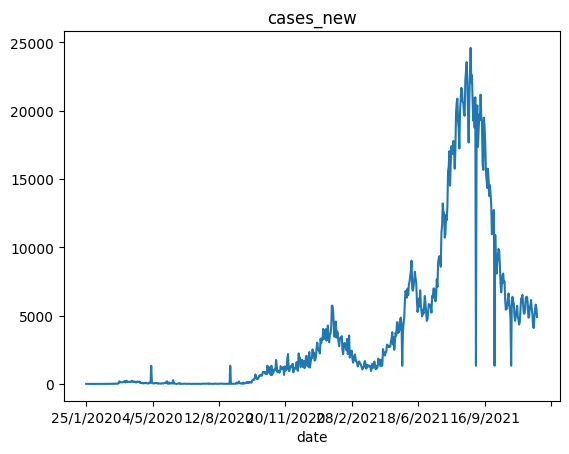

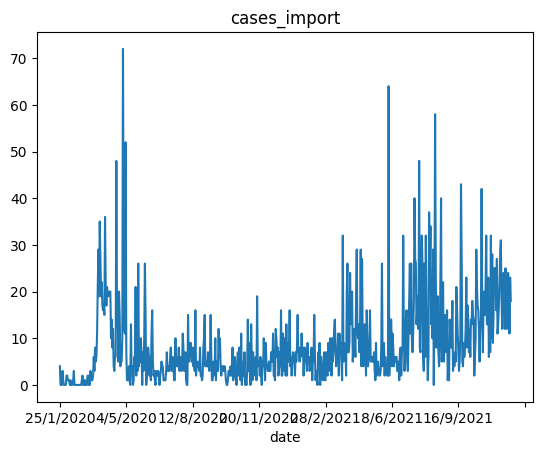

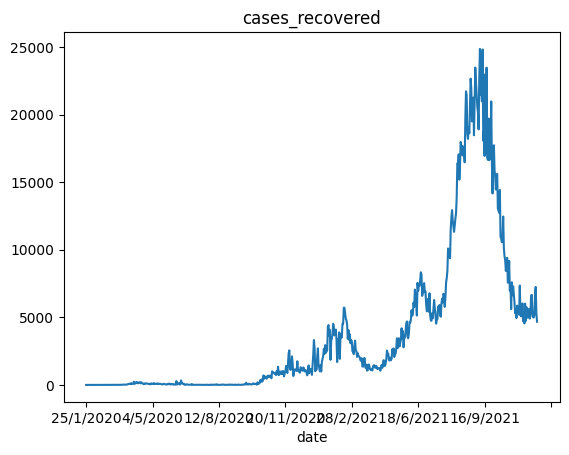

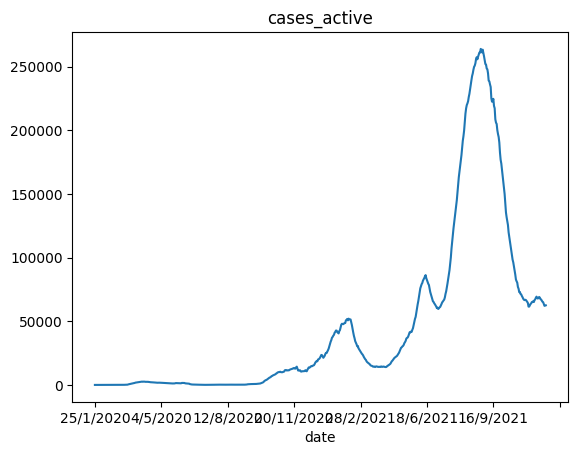

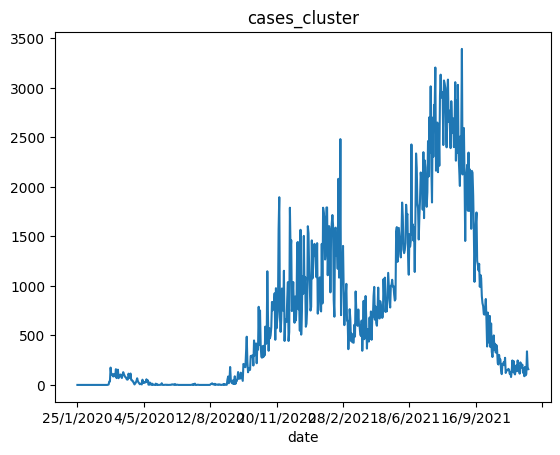

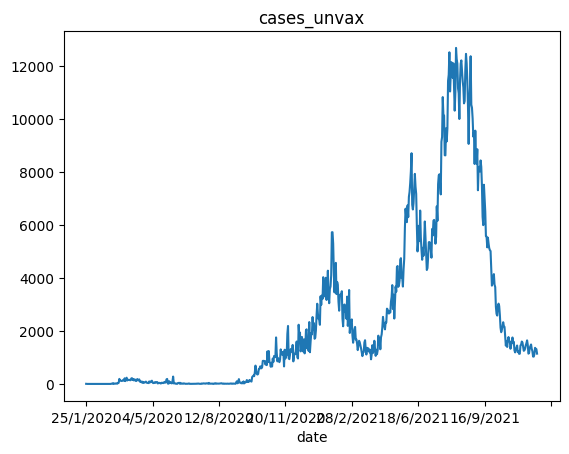

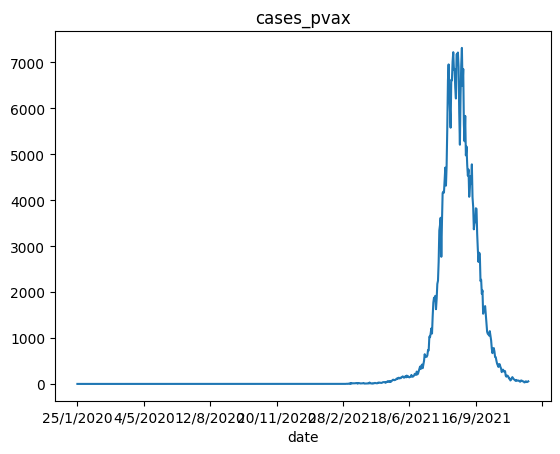

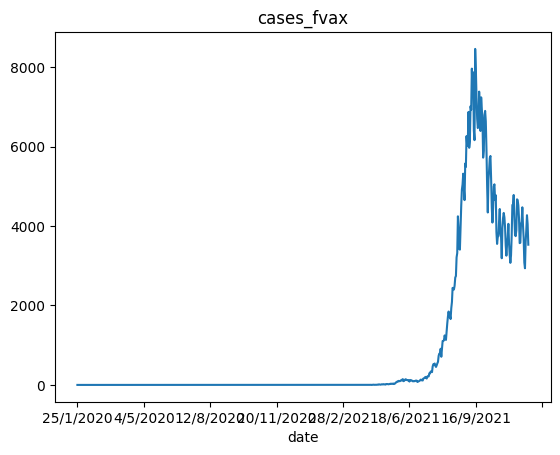

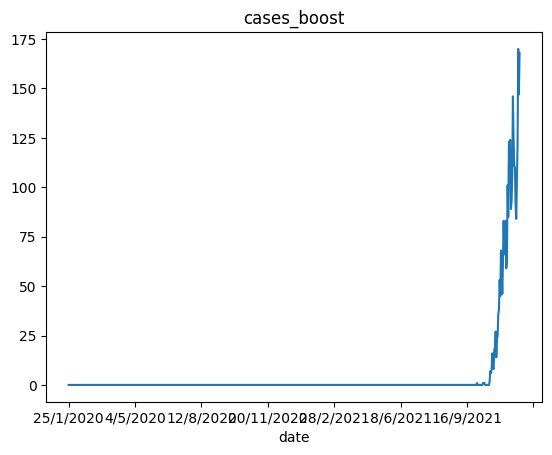

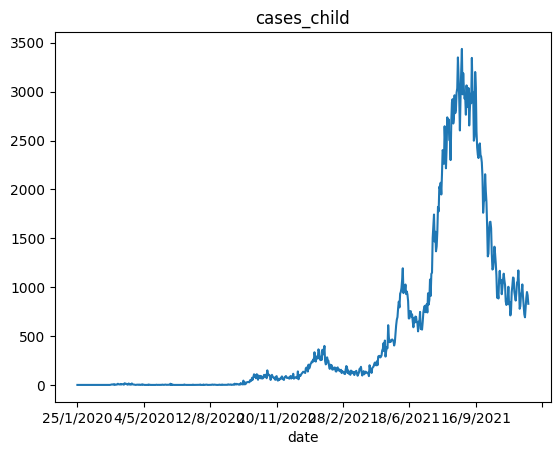

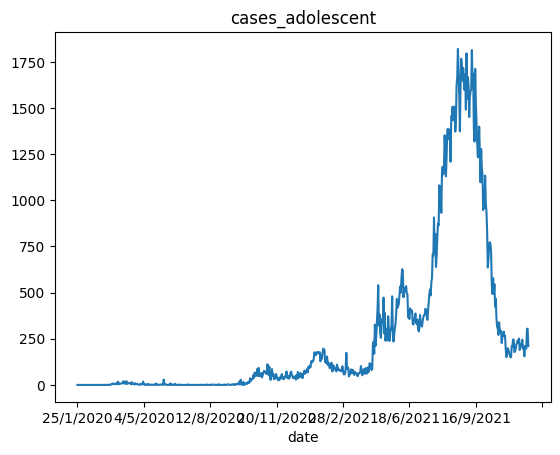

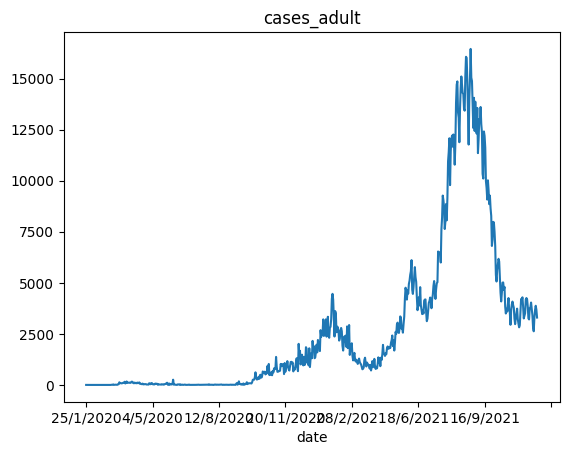

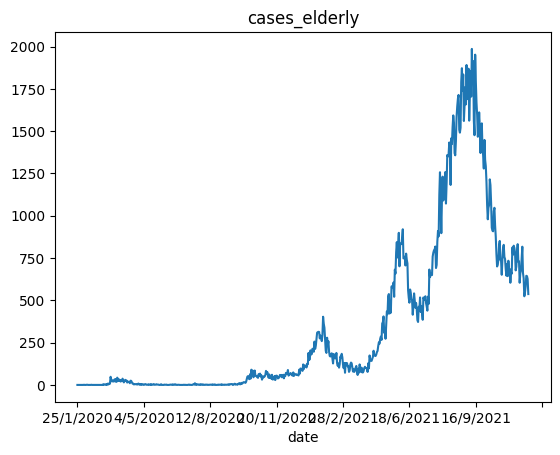

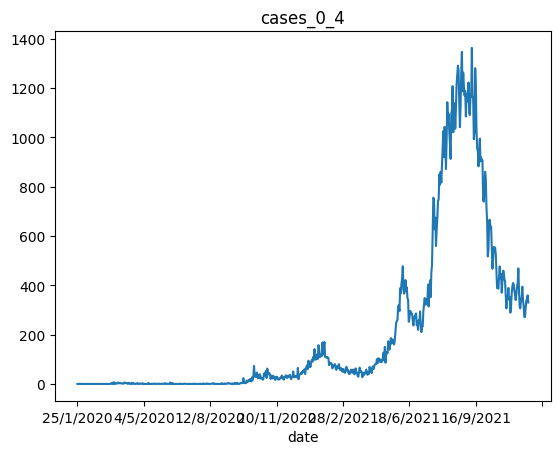

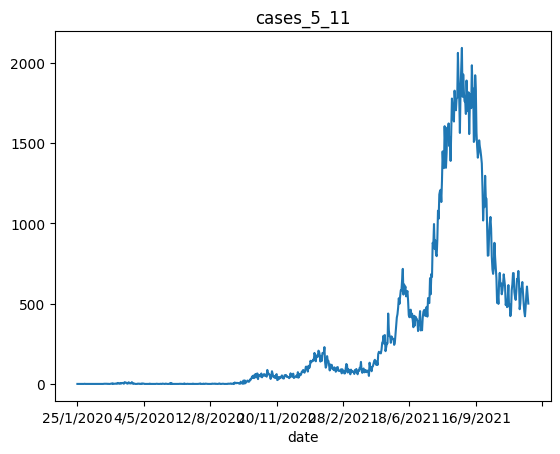

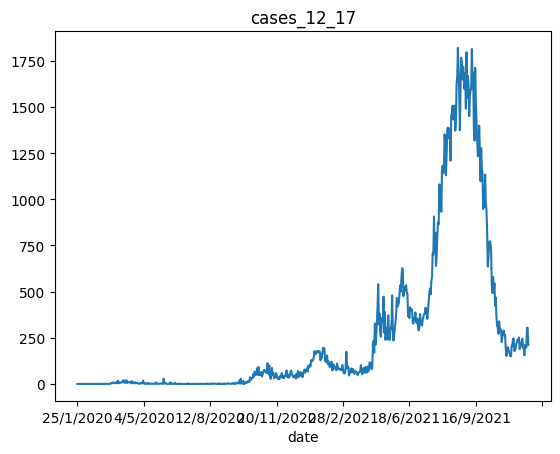

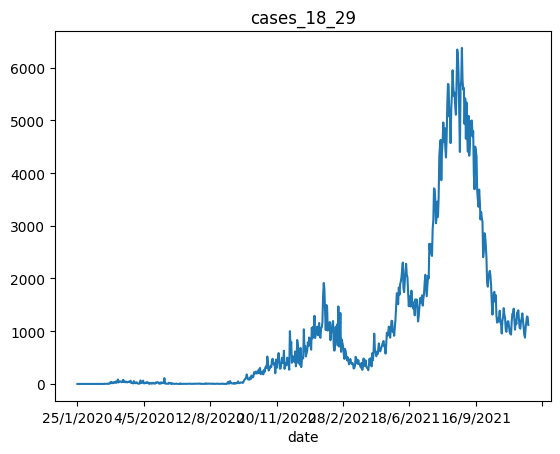

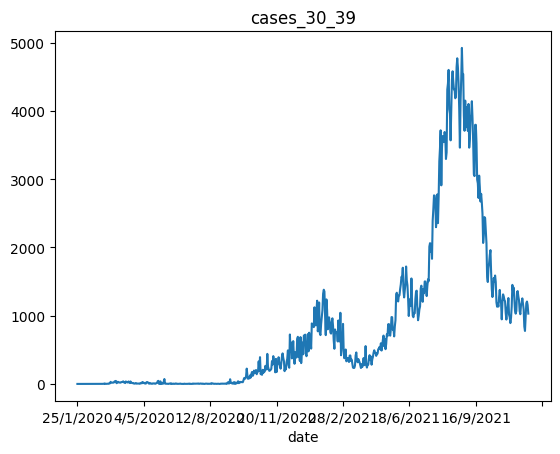

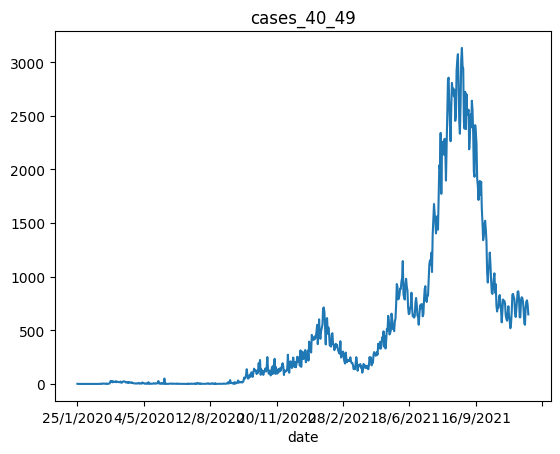

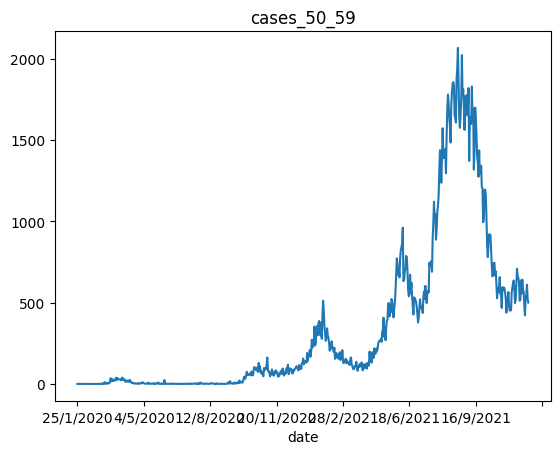

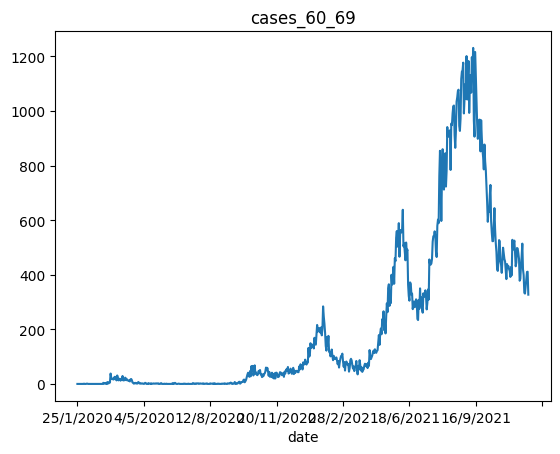

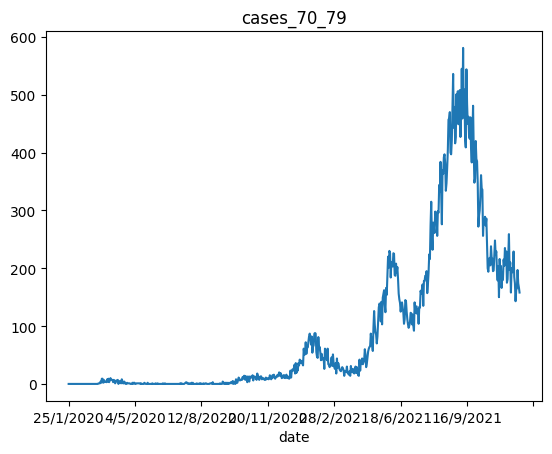

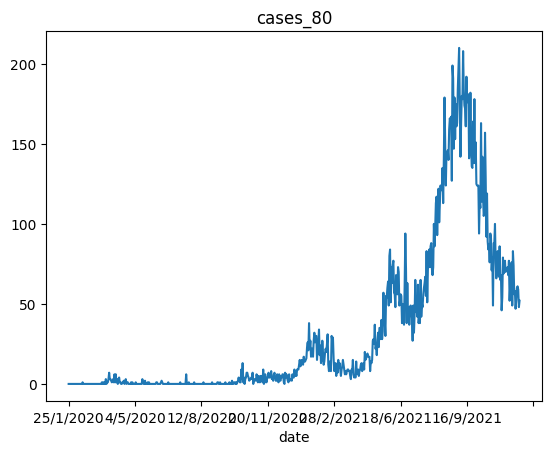

In [30]:
#Plot data

for plot_cols in train_d.columns:
    train_d[plot_cols].plot()
    plt.title(plot_cols)
    plt.show()

In [31]:
# Data already splitted
# Proceed to normalise data
train_mean = train_d.mean()
train_std = train_d.std()
train_d = (train_d - train_mean) / train_std
test_d = (test_d - train_mean) / train_std

In [32]:
# Define windows generator
# 9. Data windowing
class WindowGenerator():
  def __init__(self, input_width, label_width, shift,
               train_df=train_d, val_df=test_d, test_df=test_d,
               label_columns=None):
    # Store the raw data.
    self.train_df = train_df
    self.val_df = val_df
    self.test_df = test_df

    # Work out the label column indices.
    self.label_columns = label_columns
    if label_columns is not None:
      self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
    self.column_indices = {name: i for i, name in
                           enumerate(train_df.columns)}

    # Work out the window parameters.
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift

    self.total_window_size = input_width + shift

    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])
  
  def split_window(self, features):
    inputs = features[:, self.input_slice, :]
    labels = features[:, self.labels_slice, :]
    if self.label_columns is not None:
      labels = tf.stack(
          [labels[:, :, self.column_indices[name]] for name in self.label_columns],
          axis=-1)

    # Slicing doesn't preserve static shape information, so set the shapes
    # manually. This way the `tf.data.Datasets` are easier to inspect.
    inputs.set_shape([None, self.input_width, None])
    labels.set_shape([None, self.label_width, None])

    return inputs, labels
  
  def plot(self, model=None, plot_col='cases_new', max_subplots=3,offset = 0):
    inputs, labels = self.example
    plt.figure(figsize=(12, 8))
    plot_col_index = self.column_indices[plot_col]
    max_n = min(max_subplots, len(inputs))
    
    for n in range(max_n):
      plt.subplot(max_n, 1, n+1)
      plt.ylabel(f'{plot_col} [normed]')
      plt.plot(self.input_indices, inputs[n+offset, :, plot_col_index],
              label='Inputs', marker='.', zorder=-10)

      if self.label_columns:
        label_col_index = self.label_columns_indices.get(plot_col, None)
      else:
        label_col_index = plot_col_index

      if label_col_index is None:
        continue

      plt.scatter(self.label_indices, labels[n+offset, :, label_col_index],
                  edgecolors='k', label='Labels', c='#2ca02c', s=64)
      if model is not None:
        predictions = model(inputs)
        plt.scatter(self.label_indices, predictions[n+offset, :, label_col_index],
                    marker='X', edgecolors='k', label='Predictions',
                    c='#ff7f0e', s=64)

      if n == 0:
        plt.legend()

    plt.xlabel('Time [day]')

  def make_dataset(self, data):
    data = np.array(data, dtype=np.float32)
    ds = keras.utils.timeseries_dataset_from_array(
        data=data,
        targets=None,
        sequence_length=self.total_window_size,
        sequence_stride=1,
        shuffle=True,
        batch_size=32,)

    ds = ds.map(self.split_window)

    return ds
  
  @property
  def train(self):
    return self.make_dataset(self.train_df)

  @property
  def val(self):
    return self.make_dataset(self.val_df)

  @property
  def test(self):
    return self.make_dataset(self.test_df)

  @property
  def example(self):
    """Get and cache an example batch of `inputs, labels` for plotting."""
    result = getattr(self, '_example', None)
    if result is None:
      # No example batch was found, so get one from the `.train` dataset
      result = next(iter(self.test))
      # And cache it for next time
      self._example = result
    return result

In [33]:
# Create windows based on the requirement: nput window width of 30,output window width of 30 and an offset of 1.
Window = WindowGenerator(input_width=30,label_width=30,shift=1,label_columns=["cases_new"])
print(Window.val)


<_MapDataset element_spec=(TensorSpec(shape=(None, 30, 23), dtype=tf.float32, name=None), TensorSpec(shape=(None, 30, 1), dtype=tf.float32, name=None))>


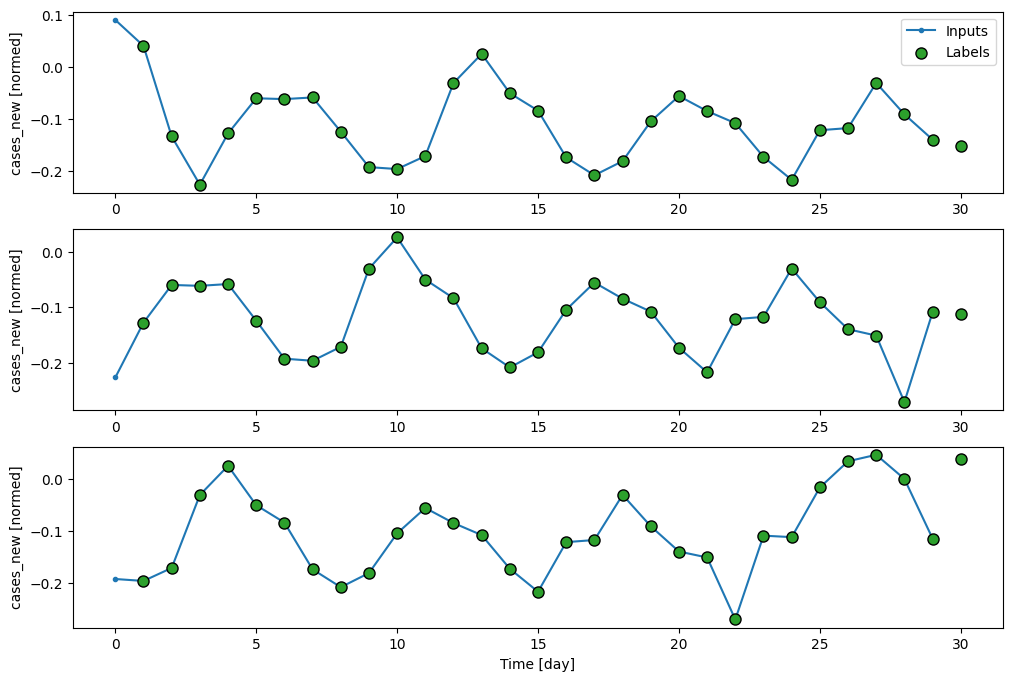

In [34]:
Window.plot(plot_col="cases_new")

In [35]:
# 10. Create an RNN (LSTM) for the wide window
model = keras.Sequential()
model.add(keras.layers.LSTM(units=16,return_sequences=True))
model.add(keras.layers.LSTM(units=32,return_sequences=True))
model.add(keras.layers.LSTM(units=64,return_sequences=True))
model.add(keras.layers.LSTM(units=32,return_sequences=True))
model.add(keras.layers.LSTM(units=16,return_sequences=True))
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_7 (LSTM)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_8 (LSTM)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_9 (LSTM)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_10 (LSTM)                  │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_11 (LSTM)                  │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [36]:
# Compile and train
model.compile(optimizer='adam',loss='mape',metrics=["mape","mse","mae"])

In [37]:
#Set up mlflow experiment
mlflow.search_experiments("Covid_Time_Series")

[]

In [38]:
#Train model and then log in mlflow
stop = keras.callbacks.EarlyStopping(patience=5,verbose=1)
with mlflow.start_run() as run:
    ml_call = mlflow.keras.MlflowCallback(run) 
    history_single = model.fit(Window.train,validation_data=Window.val,epochs=100,callbacks=[ml_call,stop])
    mlflow.keras.save.log_model(model, artifact_path='model')

Epoch 1/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 6s 53ms/step - loss: 93.7700 - mae: 0.7371 - mape: 93.7700 - mse: 1.1111 - val_loss: 524.0169 - val_mae: 1.3080 - val_mape: 524.0169 - val_mse: 4.6768
Epoch 2/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 73.6074 - mae: 0.5674 - mape: 73.6074 - mse: 0.8629 - val_loss: 778.6807 - val_mae: 1.3242 - val_mape: 778.6807 - val_mse: 4.7344
Epoch 3/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 61.1507 - mae: 0.5368 - mape: 61.1507 - mse: 0.9075 - val_loss: 880.6439 - val_mae: 1.3313 - val_mape: 880.6439 - val_mse: 4.6879
Epoch 4/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 51.7141 - mae: 0.4541 - mape: 51.7141 - mse: 0.7705 - val_loss: 1012.8137 - val_mae: 1.4127 - val_mape: 1012.8138 - val_mse: 5.2719
Epoch 5/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 49.3160 - mae: 0.4545 - mape: 49.3160 - mse: 0.7866 - val_loss: 1278.3472 - val_mae: 1.4435 - val_mape: 1278.3472 - val_mse: 5.2964
Epoch 6/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms

2025/03/10 15:39:34 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.
2025/03/10 15:39:41 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


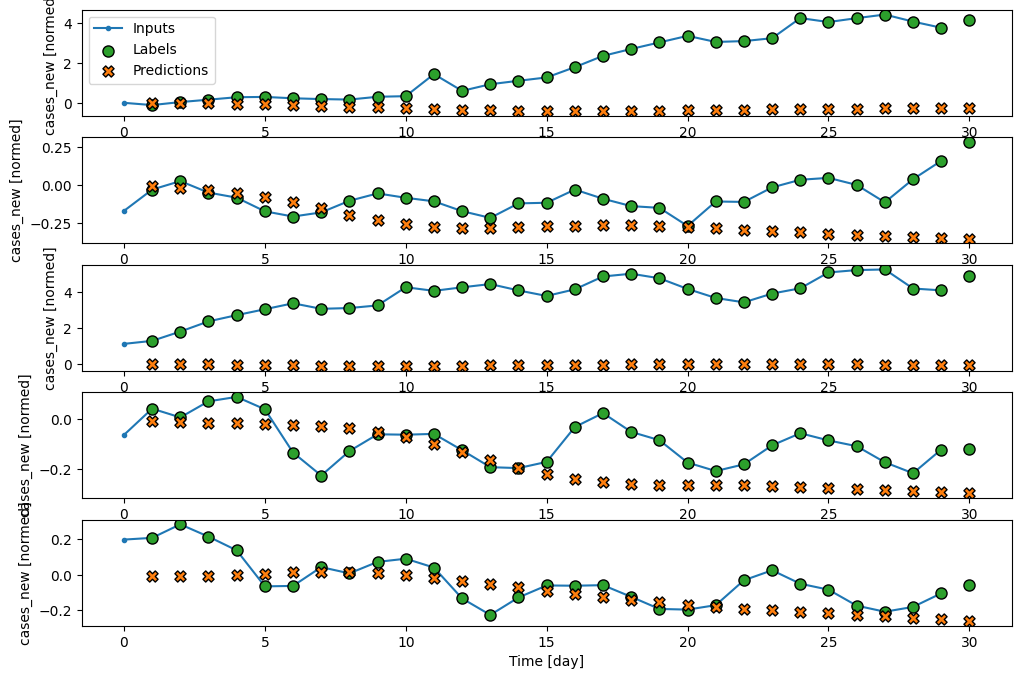

In [39]:
# Show example prediction
#print(train_d.columns)
Window.plot(model=model,plot_col="cases_new",max_subplots=5,offset=4)

In [40]:
#Load the best model from mlflow
model_best = mlflow.keras.load_model("models:/Covid_single/4")

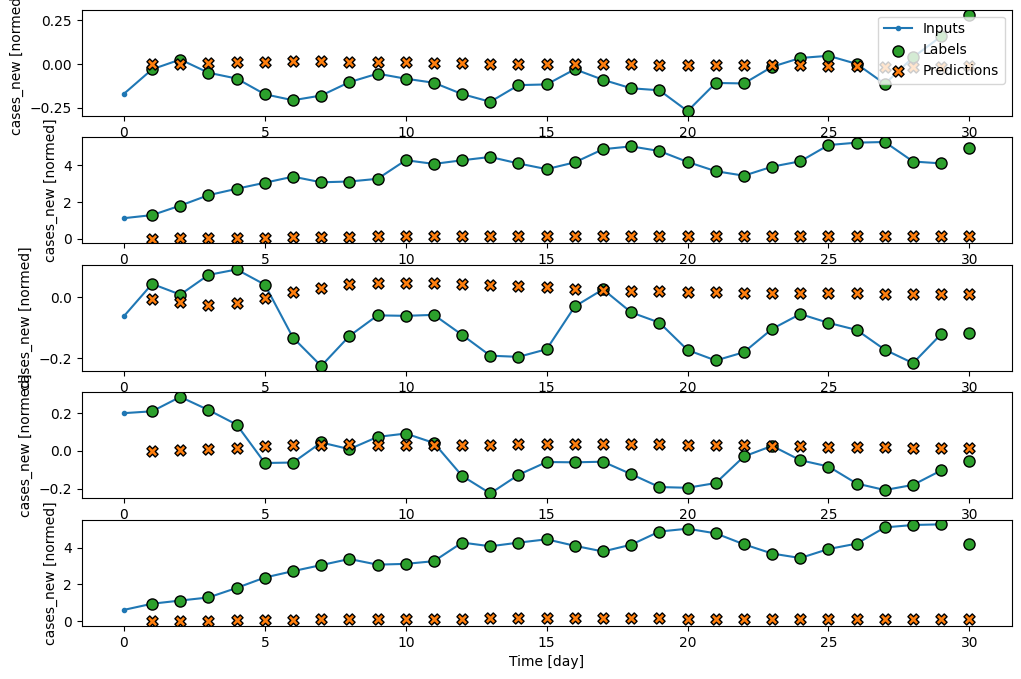

In [41]:
#Plot the best model
Window.plot(model=model_best,plot_col="cases_new",max_subplots=5,offset=5)

In [42]:
model_best.summary()

Model: "sequential_88"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_275 (LSTM)                 │ (None, 30, 16)         │         2,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_276 (LSTM)                 │ (None, 30, 32)         │         6,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_277 (LSTM)                 │ (None, 30, 64)         │        24,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_278 (LSTM)                 │ (None, 30, 32)         │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_279 (LSTM)                 │ (None, 30, 16)         │         3,136 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 147,650 (576.76 KB)

 Trainable params: 49,216 (192.25 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 98,434 (384.51 KB)

In [43]:
from keras.utils import plot_model
dot_img_file = '/tmp/model_1.png'
keras.utils.plot_model(model, to_file=dot_img_file, show_shapes=True)

You must install graphviz (see instructions at https://graphviz.gitlab.io/download/) for `plot_model` to work.
